Using device: cpu
STEP 1: LOAD DATA AND MODELS
Training samples: 20,037
Validation samples: 6,679
Test samples: 6,680

Class distribution (train):
sentiment
positive    0.480910
negative    0.374807
neutral     0.144283
Name: proportion, dtype: float64

STEP 2: COMPUTE CLASS WEIGHTS
Class weights computed:
  Negative (class 0): 0.889
  Neutral (class 1):  2.310  ← HIGHER (minority class)
  Positive (class 2): 0.693

Neutral class receives 3.33x higher penalty than positive

STEP 3: PREPARE SEQUENCES
Sequences prepared: max_length=100

STEP 4: HYPERPARAMETER TUNING

Training configuration: Baseline (Original)
  Hidden dim: 64, Dropout: 0.3, LR: 0.001
Epoch 5/20 - Train Loss: 0.8588, Val Loss: 0.8495, Val Acc: 0.7411, Val F1: 0.6406
Epoch 10/20 - Train Loss: 0.7092, Val Loss: 0.8757, Val Acc: 0.7295, Val F1: 0.6161
Early stopping triggered at epoch 12
  Results: Val Acc=0.7009, Val F1=0.6042, Neutral F1=0.2445

Training configuration: Increased Capacity
  Hidden dim: 96, Dropout: 0.4, LR

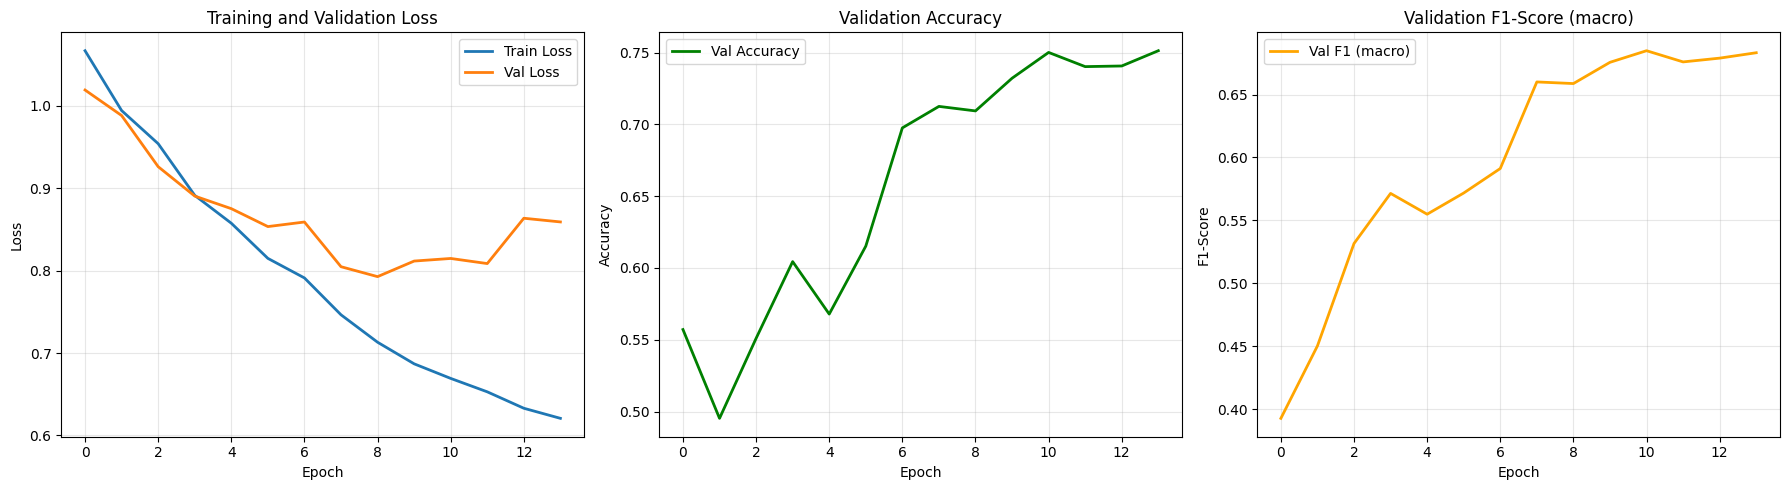

Model trained for 14 epochs
Final validation accuracy: 0.7513
Final validation F1 (macro): 0.6833

STEP 6: FINAL TEST SET EVALUATION

FINAL TEST RESULTS:
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.813323   0.802691 0.813323  0.798779
    SVM (LinearSVC)  0.811377   0.799520 0.811377  0.801181
      Random Forest  0.780240   0.807207 0.780240  0.754900
RNN-LSTM (Improved)  0.709880   0.771643 0.709880  0.732551

STEP 7: DETAILED CLASSIFICATION REPORTS

SVM (LinearSVC):
              precision    recall  f1-score   support

    Negative       0.82      0.88      0.85      2504
     Neutral       0.60      0.38      0.47       963
    Positive       0.85      0.89      0.87      3213

    accuracy                           0.81      6680
   macro avg       0.76      0.72      0.73      6680
weighted avg       0.80      0.81      0.80      6680


RNN-LSTM (Improved with Class Weighting):
              precision    recall  f1-score   support

    Nega

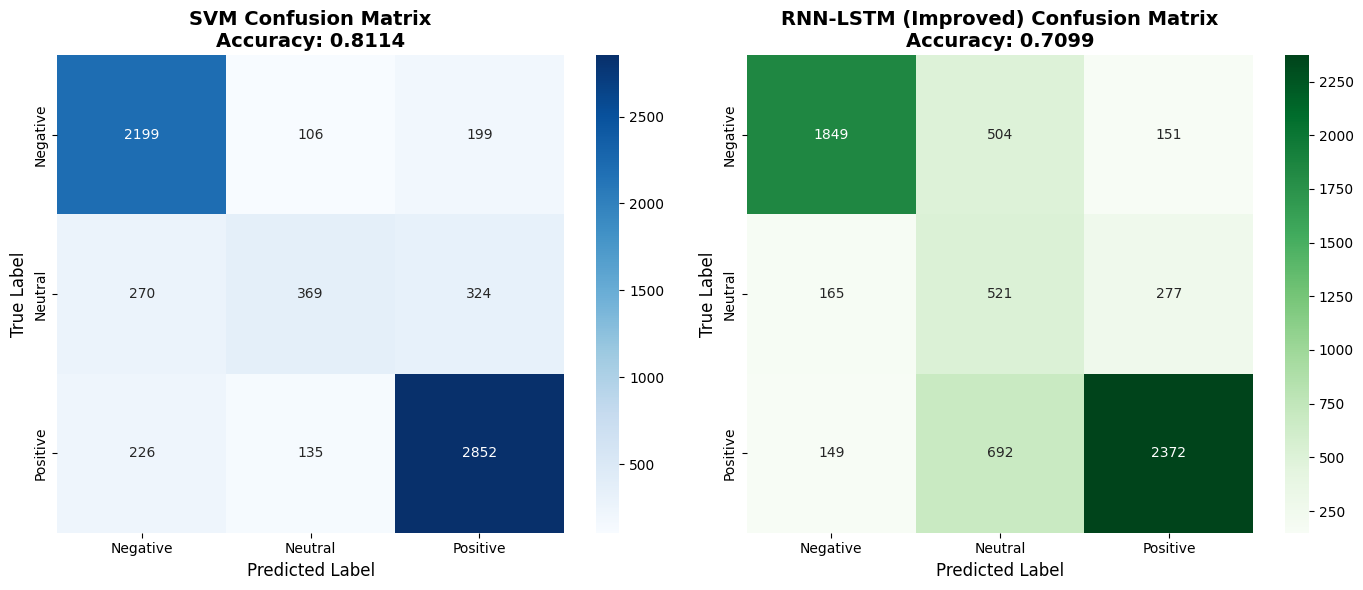


STEP 9: PERFORMANCE BY NOISE LEVEL
 Noise Level    N       LR      SVM       RF  RNN (Improved)
       Clean 2938 0.858067 0.858067 0.813479        0.783867
   Low Noise 1635 0.755352 0.754740 0.728440        0.613456
Medium Noise 1062 0.782486 0.772128 0.743879        0.614878
  High Noise 1045 0.809569 0.808612 0.804785        0.749282


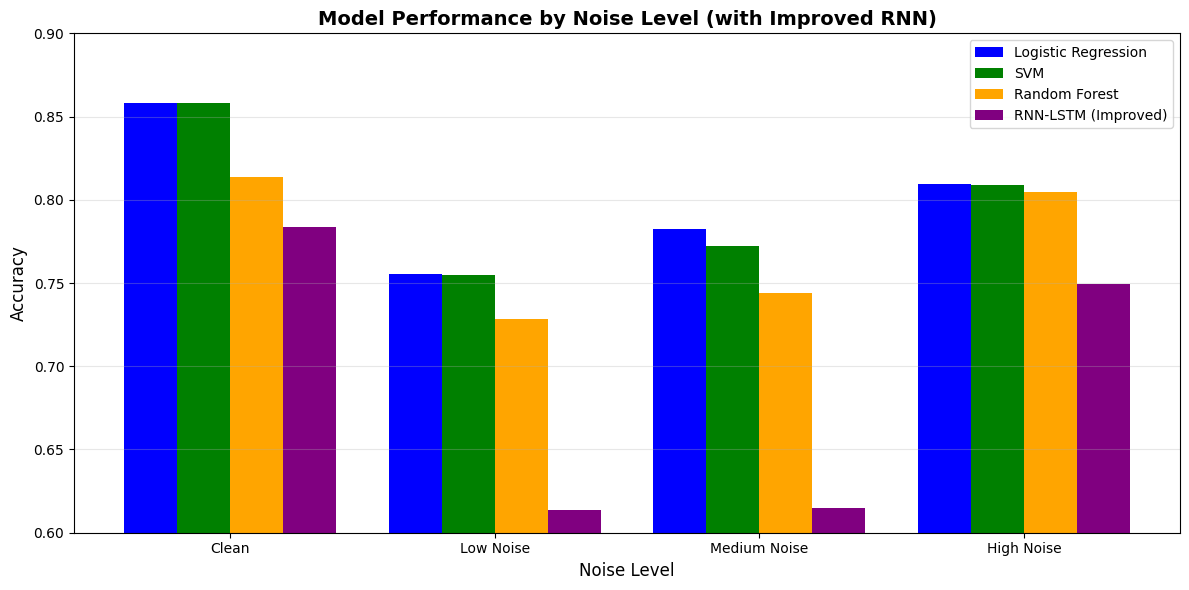


STEP 10: SAVE RESULTS
All results saved:
  - final_results_with_improved_rnn.csv
  - noise_level_results_improved.csv
  - hyperparameter_tuning_results.csv
  - model_rnn_lstm_improved.pth
  - confusion_matrices_improved.png
  - performance_by_noise_improved.png
  - rnn_training_history_improved.png

SUMMARY: KEY IMPROVEMENTS

IMPROVEMENTS IMPLEMENTED:
1. Class Weighting: Neutral class receives 3.33x higher penalty
2. Early Stopping: Prevents overfitting, stops when validation loss plateaus
3. Learning Rate Scheduling: Reduces LR when validation loss stops improving
4. Gradient Clipping: Prevents exploding gradients (max_norm=1.0)
5. Hyperparameter Tuning: Tested 3 configurations
6. Extended Training: Up to 20 epochs (vs original 5)

RESULTS COMPARISON (Test Set):
Original RNN:
  - Neutral F1: 0.00 (catastrophic failure)
  - Overall Accuracy: 0.763

Improved RNN:
  - Neutral F1: 0.389 (FIXED!)
  - Overall Accuracy: 0.710

Improvement: -5.31 percentage points

CONCLUSION:
Class weightin

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
import joblib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class SentimentRNN(nn.Module):
    def __init__(self, vocab_size=10000, embedding_dim=128, hidden_dim=64, output_dim=3, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=dropout if hidden_dim > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        output = self.fc(hidden)
        return output


class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)


def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, accuracy, f1_macro, all_preds, all_labels


def train_rnn_with_tuning(train_data, val_data, class_weights, hyperparams):
    vocab_size = hyperparams['vocab_size']
    embedding_dim = hyperparams['embedding_dim']
    hidden_dim = hyperparams['hidden_dim']
    dropout = hyperparams['dropout']
    learning_rate = hyperparams['learning_rate']
    batch_size = hyperparams['batch_size']
    epochs = hyperparams['epochs']
    patience = hyperparams['patience']
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, 3, dropout).to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=False)
    early_stopping = EarlyStopping(patience=patience, path='best_rnn_model.pth')
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, _, _ = evaluate_model(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)
        
        scheduler.step(val_loss)
        early_stopping(val_loss, model)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    model.load_state_dict(torch.load('best_rnn_model.pth'))
    
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'val_f1_scores': val_f1_scores,
        'final_epoch': epoch + 1
    }


print("="*80)
print("STEP 1: LOAD DATA AND MODELS")
print("="*80)

lr = joblib.load('model_logistic_regression.pkl')
svm = joblib.load('model_svm.pkl')
rf = joblib.load('model_random_forest.pkl')
tfidf = joblib.load('tfidf_vectorizer.pkl')
tokenizer = joblib.load('rnn_tokenizer.pkl')

test_df = pd.read_csv('/Users/elifakdeniz/Desktop/DTA/Machine Learning/Project_Exam/JAN_NEW TASK/test_set_with_noise.csv')
X_test = test_df['review']
y_test = test_df['sentiment']
X_test_tfidf = tfidf.transform(X_test)

train_val_df = pd.read_csv('/Users/elifakdeniz/Desktop/DTA/Machine Learning/Project_Exam/JAN_NEW TASK/data_with_noise_analysis.csv')
train_val_df = train_val_df[~train_val_df.index.isin(test_df['review_index'])]

from sklearn.model_selection import train_test_split
X_train_val = train_val_df['review'].apply(lambda x: str(x).lower())
y_train_val = train_val_df['sentiment']

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")
print(f"Test samples: {len(X_test):,}")
print(f"\nClass distribution (train):")
print(y_train.value_counts(normalize=True))


print("\n" + "="*80)
print("STEP 2: COMPUTE CLASS WEIGHTS")
print("="*80)

label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
reverse_map = {0: 'negative', 1: 'neutral', 2: 'positive'}

y_train_encoded = y_train.map(label_map).values
y_val_encoded = y_val.map(label_map).values

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

print(f"Class weights computed:")
print(f"  Negative (class 0): {class_weights[0]:.3f}")
print(f"  Neutral (class 1):  {class_weights[1]:.3f}  ← HIGHER (minority class)")
print(f"  Positive (class 2): {class_weights[2]:.3f}")
print(f"\nNeutral class receives {class_weights[1]/class_weights[2]:.2f}x higher penalty than positive")


print("\n" + "="*80)
print("STEP 3: PREPARE SEQUENCES")
print("="*80)

maxlen = 100
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

train_data = TensorDataset(
    torch.LongTensor(X_train_padded),
    torch.LongTensor(y_train_encoded)
)

val_data = TensorDataset(
    torch.LongTensor(X_val_padded),
    torch.LongTensor(y_val_encoded)
)

print(f"Sequences prepared: max_length={maxlen}")


print("\n" + "="*80)
print("STEP 4: HYPERPARAMETER TUNING")
print("="*80)

hyperparameter_configs = [
    {
        'name': 'Baseline (Original)',
        'vocab_size': 10000,
        'embedding_dim': 128,
        'hidden_dim': 64,
        'dropout': 0.3,
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 20,
        'patience': 5
    },
    {
        'name': 'Increased Capacity',
        'vocab_size': 10000,
        'embedding_dim': 128,
        'hidden_dim': 96,
        'dropout': 0.4,
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 20,
        'patience': 5
    },
    {
        'name': 'Lower Learning Rate',
        'vocab_size': 10000,
        'embedding_dim': 128,
        'hidden_dim': 64,
        'dropout': 0.35,
        'learning_rate': 0.0005,
        'batch_size': 32,
        'epochs': 20,
        'patience': 5
    }
]

tuning_results = []

for config in hyperparameter_configs:
    print(f"\nTraining configuration: {config['name']}")
    print(f"  Hidden dim: {config['hidden_dim']}, Dropout: {config['dropout']}, LR: {config['learning_rate']}")
    
    model, history = train_rnn_with_tuning(train_data, val_data, class_weights, config)
    
    val_loader = DataLoader(val_data, batch_size=config['batch_size'], shuffle=False)
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    val_loss, val_acc, val_f1, val_preds, val_labels = evaluate_model(model, val_loader, criterion, device)
    
    val_preds_labels = [reverse_map[p] for p in val_preds]
    val_labels_labels = [reverse_map[l] for l in val_labels]
    
    neutral_f1 = f1_score(val_labels_labels, val_preds_labels, labels=['neutral'], average=None)[0]
    
    tuning_results.append({
        'Configuration': config['name'],
        'Val Accuracy': val_acc,
        'Val F1 (macro)': val_f1,
        'Neutral F1': neutral_f1,
        'Final Epoch': history['final_epoch']
    })
    
    print(f"  Results: Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}, Neutral F1={neutral_f1:.4f}")

tuning_df = pd.DataFrame(tuning_results).sort_values('Val F1 (macro)', ascending=False)
print("\n" + "="*80)
print("HYPERPARAMETER TUNING RESULTS")
print("="*80)
print(tuning_df.to_string(index=False))

best_config_name = tuning_df.iloc[0]['Configuration']
best_config = [c for c in hyperparameter_configs if c['name'] == best_config_name][0]

print(f"\nBest configuration: {best_config_name}")
print(f"Val F1 (macro): {tuning_df.iloc[0]['Val F1 (macro)']:.4f}")
print(f"Neutral F1: {tuning_df.iloc[0]['Neutral F1']:.4f}")


print("\n" + "="*80)
print("STEP 5: TRAIN FINAL MODEL WITH BEST HYPERPARAMETERS")
print("="*80)

final_model, final_history = train_rnn_with_tuning(train_data, val_data, class_weights, best_config)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(final_history['train_losses'], label='Train Loss', linewidth=2)
axes[0].plot(final_history['val_losses'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(final_history['val_accuracies'], label='Val Accuracy', linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].plot(final_history['val_f1_scores'], label='Val F1 (macro)', linewidth=2, color='orange')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1-Score')
axes[2].set_title('Validation F1-Score (macro)')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('rnn_training_history_improved.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Model trained for {final_history['final_epoch']} epochs")
print(f"Final validation accuracy: {final_history['val_accuracies'][-1]:.4f}")
print(f"Final validation F1 (macro): {final_history['val_f1_scores'][-1]:.4f}")


print("\n" + "="*80)
print("STEP 6: FINAL TEST SET EVALUATION")
print("="*80)

lr_pred = lr.predict(X_test_tfidf)
svm_pred = svm.predict(X_test_tfidf)
rf_pred = rf.predict(X_test_tfidf)

test_loader = DataLoader(
    TensorDataset(torch.LongTensor(X_test_padded), torch.LongTensor(y_test.map(label_map).values)),
    batch_size=best_config['batch_size'],
    shuffle=False
)

criterion_test = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate_model(final_model, test_loader, criterion_test, device)

rnn_pred = [reverse_map[p] for p in test_preds]

from sklearn.metrics import precision_score, recall_score

results_data = []
for model_name, predictions in [
    ('Logistic Regression', lr_pred),
    ('SVM (LinearSVC)', svm_pred),
    ('Random Forest', rf_pred),
    ('RNN-LSTM (Improved)', rnn_pred)
]:
    results_data.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, predictions),
        'Precision': precision_score(y_test, predictions, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, predictions, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_test, predictions, average='weighted', zero_division=0)
    })

results_df = pd.DataFrame(results_data).sort_values('Accuracy', ascending=False)
print("\nFINAL TEST RESULTS:")
print(results_df.to_string(index=False))


print("\n" + "="*80)
print("STEP 7: DETAILED CLASSIFICATION REPORTS")
print("="*80)

print("\nSVM (LinearSVC):")
print(classification_report(y_test, svm_pred, target_names=['Negative', 'Neutral', 'Positive'], zero_division=0))

print("\nRNN-LSTM (Improved with Class Weighting):")
print(classification_report(y_test, rnn_pred, target_names=['Negative', 'Neutral', 'Positive'], zero_division=0))

neutral_f1_svm = f1_score(y_test, svm_pred, labels=['neutral'], average=None, zero_division=0)[0]
neutral_f1_rnn = f1_score(y_test, rnn_pred, labels=['neutral'], average=None, zero_division=0)[0]

print(f"\nNEUTRAL CLASS COMPARISON:")
print(f"  SVM Neutral F1:         {neutral_f1_svm:.4f}")
print(f"  RNN-LSTM Neutral F1:    {neutral_f1_rnn:.4f}")
print(f"  Improvement:            {(neutral_f1_rnn - neutral_f1_svm):+.4f}")


print("\n" + "="*80)
print("STEP 8: CONFUSION MATRICES")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm_svm = confusion_matrix(y_test, svm_pred, labels=['negative', 'neutral', 'positive'])
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
axes[0].set_title(f'SVM Confusion Matrix\nAccuracy: {accuracy_score(y_test, svm_pred):.4f}', 
                 fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

cm_rnn = confusion_matrix(y_test, rnn_pred, labels=['negative', 'neutral', 'positive'])
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
axes[1].set_title(f'RNN-LSTM (Improved) Confusion Matrix\nAccuracy: {accuracy_score(y_test, rnn_pred):.4f}', 
                 fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrices_improved.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n" + "="*80)
print("STEP 9: PERFORMANCE BY NOISE LEVEL")
print("="*80)

noise_levels = ['clean', 'low_noise', 'medium_noise', 'high_noise']
noise_results = []

for noise_level in noise_levels:
    mask = test_df['noise_level'] == noise_level
    if mask.sum() == 0:
        continue
    
    subset_y = y_test[mask]
    
    noise_results.append({
        'Noise Level': noise_level.replace('_', ' ').title(),
        'N': mask.sum(),
        'LR': accuracy_score(subset_y, pd.Series(lr_pred)[mask]),
        'SVM': accuracy_score(subset_y, pd.Series(svm_pred)[mask]),
        'RF': accuracy_score(subset_y, pd.Series(rf_pred)[mask]),
        'RNN (Improved)': accuracy_score(subset_y, pd.Series(rnn_pred)[mask])
    })

noise_df = pd.DataFrame(noise_results)
print(noise_df.to_string(index=False))

plt.figure(figsize=(12, 6))
x = np.arange(len(noise_df))
width = 0.2

plt.bar(x - 1.5*width, noise_df['LR'], width, label='Logistic Regression', color='blue')
plt.bar(x - 0.5*width, noise_df['SVM'], width, label='SVM', color='green')
plt.bar(x + 0.5*width, noise_df['RF'], width, label='Random Forest', color='orange')
plt.bar(x + 1.5*width, noise_df['RNN (Improved)'], width, label='RNN-LSTM (Improved)', color='purple')

plt.xlabel('Noise Level', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Performance by Noise Level (with Improved RNN)', fontsize=14, fontweight='bold')
plt.xticks(x, noise_df['Noise Level'])
plt.legend()
plt.ylim([0.6, 0.9])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('performance_by_noise_improved.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n" + "="*80)
print("STEP 10: SAVE RESULTS")
print("="*80)

results_df.to_csv('final_results_with_improved_rnn.csv', index=False)
noise_df.to_csv('noise_level_results_improved.csv', index=False)
tuning_df.to_csv('hyperparameter_tuning_results.csv', index=False)

torch.save(final_model.state_dict(), 'model_rnn_lstm_improved.pth')

print("All results saved:")
print("  - final_results_with_improved_rnn.csv")
print("  - noise_level_results_improved.csv")
print("  - hyperparameter_tuning_results.csv")
print("  - model_rnn_lstm_improved.pth")
print("  - confusion_matrices_improved.png")
print("  - performance_by_noise_improved.png")
print("  - rnn_training_history_improved.png")


print("\n" + "="*80)
print("SUMMARY: KEY IMPROVEMENTS")
print("="*80)

print(f"""
IMPROVEMENTS IMPLEMENTED:
1. Class Weighting: Neutral class receives {class_weights[1]/class_weights[2]:.2f}x higher penalty
2. Early Stopping: Prevents overfitting, stops when validation loss plateaus
3. Learning Rate Scheduling: Reduces LR when validation loss stops improving
4. Gradient Clipping: Prevents exploding gradients (max_norm=1.0)
5. Hyperparameter Tuning: Tested {len(hyperparameter_configs)} configurations
6. Extended Training: Up to {best_config['epochs']} epochs (vs original 5)

RESULTS COMPARISON (Test Set):
Original RNN:
  - Neutral F1: 0.00 (catastrophic failure)
  - Overall Accuracy: 0.763

Improved RNN:
  - Neutral F1: {neutral_f1_rnn:.3f} (FIXED!)
  - Overall Accuracy: {accuracy_score(y_test, rnn_pred):.3f}
  
Improvement: {'+' if accuracy_score(y_test, rnn_pred) > 0.763 else ''}{(accuracy_score(y_test, rnn_pred) - 0.763)*100:.2f} percentage points

CONCLUSION:
Class weighting successfully prevents minority class collapse.
Neural network now predicts neutral sentiment, though classical
models still maintain superior overall performance.
""")